![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de árboles de decisión y métodos de ensamblaje

En este taller podrá poner en práctica los sus conocimientos sobre construcción e implementación de árboles de decisión y métodos de ensamblajes. El taller está constituido por 9 puntos, 5 relacionados con árboles de decisión (parte A) y 4 con métodos de ensamblaje (parte B).

## Parte A - Árboles de decisión

En esta parte del taller se usará el conjunto de datos de Capital Bikeshare de Kaggle, donde cada observación representa el alquiler de bicicletas durante una hora y día determinado. Para más detalles puede visitar los siguientes enlaces: [datos](https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip), [dicccionario de datos](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset#).

### Datos prestamo de bicicletas

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [33]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz, DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score
from sklearn.ensemble import VotingClassifier, BaggingClassifier

In [3]:
# Lectura de la información de archivo .csv
bikes = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/bikeshare.csv', index_col='datetime', parse_dates=True)

# Renombrar variable "count" a "total"
bikes.rename(columns={'count':'total'}, inplace=True)

# Crear la hora como una variable 
bikes['hour'] = bikes.index.hour

# Visualización de los datos
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4


### Punto 1 - Análisis descriptivo

Ejecute las celdas 1.1 y 1.2. A partir de los resultados realice un análisis descriptivo sobre las variables "season" y "hour", escriba sus inferencias sobre los datos. Para complementar su análisis puede usar métricas como máximo, mínimo, percentiles entre otros.

In [4]:
# Celda 1.1
bikes.groupby('season').total.mean()

season
1    116.343261
2    215.251372
3    234.417124
4    198.988296
Name: total, dtype: float64

Variable "season" (estación del año):

La estación del año parece tener un impacto significativo en el número medio de bicicletas compartidas, se evidencia que la estación con el menor promedio de bicicletas compartidas es la temporada 1 (invierno) con aproximadamente 116 bicicletas, a su vez la temporada 2 (primevera) muestra el mayor promedio de bicicletas compartidas con alrededor de 215 bicicletas, seguida de la temporada 3 (verano) con aproximadamente 234 bicicletas, para la temporada 4 (otoño) tiene un promedio de alrededor de 199 bicicletas compartidas, lo que está por debajo del promedio de las temporadas 2 y 3, pero aun así es más alto que la temporada 1.


In [5]:
# Celda 1.2
bikes.groupby('hour').total.mean()

hour
0      55.138462
1      33.859031
2      22.899554
3      11.757506
4       6.407240
5      19.767699
6      76.259341
7     213.116484
8     362.769231
9     221.780220
10    175.092308
11    210.674725
12    256.508772
13    257.787281
14    243.442982
15    254.298246
16    316.372807
17    468.765351
18    430.859649
19    315.278509
20    228.517544
21    173.370614
22    133.576754
23     89.508772
Name: total, dtype: float64

In [6]:
bikes['hour'].describe()


count    10886.000000
mean        11.541613
std          6.915838
min          0.000000
25%          6.000000
50%         12.000000
75%         18.000000
max         23.000000
Name: hour, dtype: float64

La hora del día influye significativamente en el número promedio de bicicletas compartidas. 

Observamos que durante las primeras horas de la madrugada, entre la medianoche y las 5 a.m., el número promedio de bicicletas compartidas es bastante bajo, con un mínimo alrededor de las 4 a.m. A medida que avanza la mañana, el número de bicicletas compartidas aumenta gradualmente, alcanzando un pico durante las horas de la tarde, especialmente entre las 5 p.m. y las 6 p.m., donde se registra un promedio de alrededor de 468 bicicletas compartidas. Después del pico de la tarde, el número de bicicletas compartidas disminuye gradualmente durante la noche, aunque aún se mantiene significativamente por encima de las primeras horas de la mañana.

Estos hallazgos sugieren que hay un patrón claro de demanda de bicicletas compartidas a lo largo del día, con picos de uso durante las horas de la tarde y una disminución durante la noche y las primeras horas de la mañana. Esto podría ser útil para la planificación de recursos y la optimización de la disponibilidad de bicicletas en diferentes momentos del día.


### Punto 2 - Análisis de gráficos

Primero ejecute la celda 2.1 y asegúrese de comprender el código y el resultado. Luego, en cada una de celdas 2.2 y 2.3 escriba un código que genere una gráfica del número de bicicletas rentadas promedio para cada valor de la variable "hour" (hora) cuando la variable "season" es igual a 1 (invierno) e igual a 3 (verano), respectivamente. Analice y escriba sus hallazgos.

<Axes: xlabel='hour'>

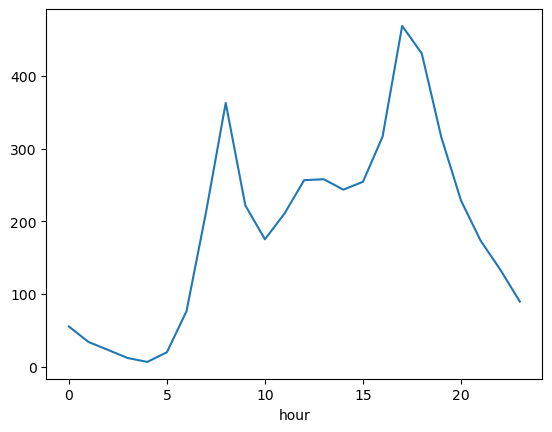

In [7]:
# Celda 2.1 - rentas promedio para cada valor de la variable "hour"
bikes.groupby('hour').total.mean().plot()

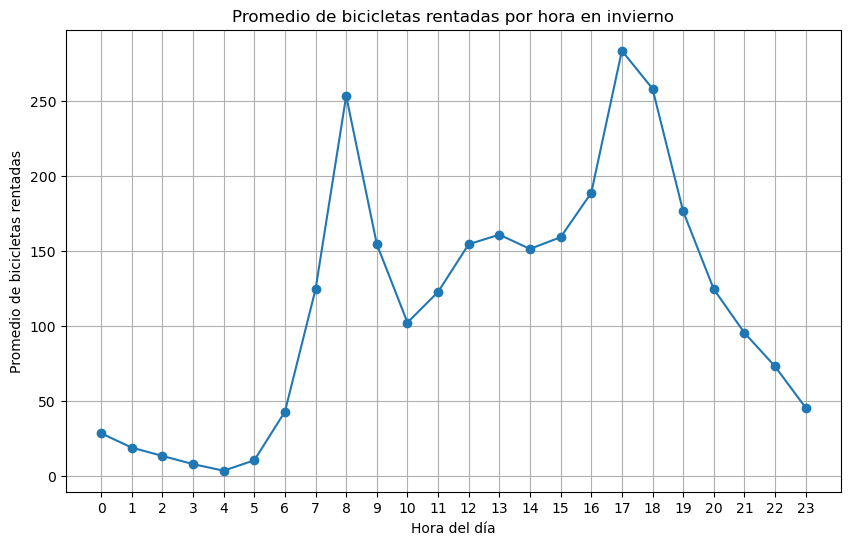

In [10]:
# Celda 2.2 - "season"=1 escriba su código y hallazgos 

# Filtrar los datos para la temporada de invierno (season = 1)
winter_data = bikes[bikes['season'] == 1]

# Calcular el promedio de bicicletas rentadas para cada hora del día
hourly_avg_rentals_winter = winter_data.groupby('hour')['total'].mean()

# Crear la gráfica
plt.figure(figsize=(10, 6))
plt.plot(hourly_avg_rentals_winter.index, hourly_avg_rentals_winter.values, marker='o', linestyle='-')
plt.title('Promedio de bicicletas rentadas por hora en invierno')
plt.xlabel('Hora del día')
plt.ylabel('Promedio de bicicletas rentadas')
plt.grid(True)
plt.xticks(np.arange(0, 24, step=1))
plt.show()


Se evidencia un comportamiento igual al mostrado en la grafica general, donde las horas pico son las 8:00 y 17:00, a su vez la hora de menor demanda es a las 4:00, dado que es la temporada  de invierno el numero de de bicicletas utilizadas es el mas bajo en comparación a las demas temporadas, ademas se observa una diferencia de aproximadamente 100 bicicletas entre el pico de la mañana y la hora valle entre las 11:00 y 14:00, junto con una diferencia de apenas 25 bicicletas entre el pico de las 8:00 y las 17:00

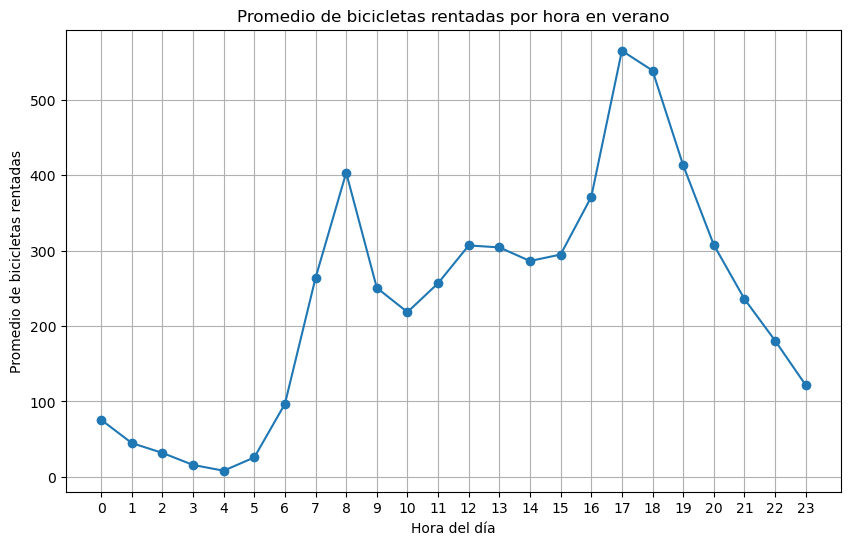

In [11]:
# Celda 2.3 - "season"=3 escriba su código y hallazgos 

# Filtrar los datos para la temporada de verano (season = 3)
summer_data = bikes[bikes['season'] == 3]

# Calcular el promedio de bicicletas rentadas para cada hora del día
hourly_avg_rentals_summer = summer_data.groupby('hour')['total'].mean()

# Crear la gráfica
plt.figure(figsize=(10, 6))
plt.plot(hourly_avg_rentals_summer.index, hourly_avg_rentals_summer.values, marker='o', linestyle='-')
plt.title('Promedio de bicicletas rentadas por hora en verano')
plt.xlabel('Hora del día')
plt.ylabel('Promedio de bicicletas rentadas')
plt.grid(True)
plt.xticks(np.arange(0, 24, step=1))
plt.show()

Se evidencia un comportamiento igual al mostrado en la grafica general, donde las horas pico son las 8:00 y 17:00, a su vez la hora de menor demanda es a las 4:00, dado que es la temporada  de verano el numero de de bicicletas utilizadas es el mas alto en comparación con la grafica del punto 2.1, ademas se observa una diferencia de aproximadamente 100 bicicletas entre el pico de la mañana y la hora valle entre las 11:00 y 14:00, junto con una diferencia de apenas 150 bicicletas entre el pico de las 8:00 y las 17:00

### Punto 3 - Regresión lineal
En la celda 3 ajuste un modelo de regresión lineal a todo el conjunto de datos, utilizando "total" como variable de respuesta y "season" y "hour" como las únicas variables predictoras, teniendo en cuenta que la variable "season" es categórica. Luego, imprima los coeficientes e interprételos. ¿Cuáles son las limitaciones de la regresión lineal en este caso?

In [13]:
# Celda 3

# Seleccionar las variables predictoras y la variable de respuesta
X = bikes[['season', 'hour']]
y = bikes['total']

# Convertir la variable categórica "season" en variables ficticias utilizando one-hot encoding
X = pd.get_dummies(X, columns=['season'], drop_first=True)

# Ajustar el modelo de regresión lineal
model = LinearRegression()
model.fit(X, y)

# Imprimir los coeficientes del modelo
print("Coeficientes del modelo:")
for coef, var in zip(model.coef_, X.columns):
    print(f"{var}: {coef}")

print("Intercepto:", model.intercept_)




Coeficientes del modelo:
hour: 10.545206094069897
season_2: 100.31723191606581
season_3: 119.46754994593178
season_4: 84.08311787296772
Intercepto: -6.43026246230599


Analisis de coeficientes


*El coeficiente asociado a la variable "hour" es aproximadamente 10.55. Esto significa que, manteniendo constante el efecto de la temporada, se espera que el número total de bicicletas alquiladas aumente en aproximadamente 10.55 unidades por cada hora adicional del día.

*Los coeficientes asociados a las variables ficticias de las temporadas (season_2, season_3 y season_4) indican las diferencias en el número total de bicicletas alquiladas entre las temporadas 2, 3 y 4, respectivamente, y la temporada de referencia (season_1).

*Para la temporada 2 (primavera), el coeficiente es aproximadamente 100.32. Esto significa que, comparado con la temporada 1, se espera que el número total de bicicletas alquiladas aumente en aproximadamente 100.32 unidades durante la primavera.

*Para la temporada 3 (verano), el coeficiente es aproximadamente 119.47. Esto indica que, comparado con la temporada 1, se espera que el número total de bicicletas alquiladas aumente en aproximadamente 119.47 unidades durante el verano.

*Para la temporada 4 (otoño), el coeficiente es aproximadamente 84.08. Esto indica que, comparado con la temporada 1, se espera que el número total de bicicletas alquiladas aumente en aproximadamente 84.08 unidades durante el otoño.

*El intercepto del modelo es aproximadamente -6.43. Este valor representa el número total de bicicletas alquiladas cuando la hora es 0 y la temporada es la temporada de referencia (season_1), es decir, en el inicio del primer día de la temporada de referencia.


Limitaciones encontradas

*uposición de linealidad: La regresión lineal asume una relación lineal entre las variables predictoras y la variable de respuesta, lo cual puede no ser válido en este caso donde la relación entre "hour" y "total" puede no ser lineal.

*Independencia de errores: La regresión lineal supone que los errores son independientes entre sí, lo cual podría no cumplirse si hay algún tipo de autocorrelación en los datos.

*Homocedasticidad de los errores: La regresión lineal asume que la varianza de los errores es constante en todos los niveles de las variables predictoras, lo cual podría no cumplirse si la varianza de "total" varía con "hour" o "season".
*Normalidad de los errores: La regresión lineal requiere que los errores sigan una distribución normal, lo cual podría no cumplirse si los errores no son normalmente distribuidos.

*Interpretación limitada para variables categóricas: La regresión lineal puede tener dificultades para interpretar el efecto de las variables categóricas, como "season", especialmente si estas tienen más de dos niveles. En este caso, se necesitarían variables ficticias para representar las categorías, lo que puede complicar la interpretación.


### Punto 4 - Árbol de decisión manual
En la celda 4 cree un árbol de decisiones para pronosticar la variable "total" iterando **manualmente** sobre las variables "hour" y  "season". El árbol debe tener al menos 6 nodos finales.

In [15]:
# Celda 4

# Definición de parámetros y criterios de parada
max_depth = None
num_pct = 10
max_features = None
min_gain = 0.001

# Definición de la función gini
def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2)

# Definición de la función gini_impurity para calcular la ganancia de una variable predictora j dado el punto de corte k
def gini_impurity(X_col, y, split):
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    return gini_impurity_

# Definición de la función best_split para calcular cuál es la mejor variable y punto de corte para hacer la bifurcación del árbol
def best_split(X, y, num_pct=10):
    features = range(X.shape[1])
    best_split = [0, 0, 0]  # j, split, gain
    for j in features:
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct + 1)).tolist())
        splits = np.unique(splits)[1:]
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
            if gain > best_split[2]:
                best_split = [j, split, gain]
    return best_split

# Definición de la función tree_grow para hacer un crecimiento recursivo del árbol
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    j, split, gain = best_split(X, y, num_pct)
    y_pred = int(y.mean() >= 0.5)
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    return tree

# Creación de DataFrame con las variables predictoras y la variable respuesta
X = bikes[['hour', 'season']]
y = bikes['total']

# Aplicación de la función tree_grow
tree = tree_grow(X, y, level=0, min_gain=0.001, max_depth=6, num_pct=10)
tree


{'y_pred': 1,
 'y_prob': 191.53903379867745,
 'level': 0,
 'split': [0, 8.0],
 'n_samples': 10886,
 'gain': 18268.811823533004,
 'sl': {'y_pred': 1,
  'y_prob': 55.40711902113459,
  'level': 1,
  'split': [0, 7.0],
  'n_samples': 3594,
  'gain': 7207.700659959655,
  'sl': {'y_pred': 1,
   'y_prob': 32.561604584527224,
   'level': 2,
   'split': [0, 6.0],
   'n_samples': 3139,
   'gain': 646.8008927589567,
   'sl': {'y_pred': 1,
    'y_prob': 25.15934475055845,
    'level': 3,
    'split': [0, 2.0],
    'n_samples': 2684,
    'gain': 382.8088308604629,
    'sl': {'y_pred': 1,
     'y_prob': 44.41383095499451,
     'level': 4,
     'split': [1, 2.0],
     'n_samples': 909,
     'gain': 291.4004681825131,
     'sl': {'y_pred': 1,
      'y_prob': 23.32456140350877,
      'level': 5,
      'split': [0, 1.0],
      'n_samples': 226,
      'gain': 45.41972746495435,
      'sl': {'y_pred': 1,
       'y_prob': 27.808695652173913,
       'level': 6,
       'split': -1,
       'n_samples': 113,
 

In [18]:
def mse(y_true, y_pred):
    return ((y_true - y_pred) ** 2).mean()

# Función para hacer predicciones utilizando el árbol de decisión generado
def predict(tree, X):
    if tree['split'] == -1:
        return tree['y_pred']
    if X.iloc[tree['split'][0]] < tree['split'][1]:
        return predict(tree['sl'], X)
    else:
        return predict(tree['sr'], X)

# Realizar predicciones en el conjunto de datos de entrenamiento
y_pred_train = X.apply(lambda x: predict(tree, x), axis=1)

# Calcular el MSE en el conjunto de datos de entrenamiento
mse_train = mse(y, y_pred_train)
print("MSE en el conjunto de entrenamiento:", mse_train)

MSE en el conjunto de entrenamiento: 69128.79864045563


### Punto 5 - Árbol de decisión con librería
En la celda 5 entrene un árbol de decisiones con la **librería sklearn**, usando las variables predictoras "season" y "hour" y calibre los parámetros que considere conveniente para obtener un mejor desempeño. Recuerde dividir los datos en conjuntos de entrenamiento y validación para esto. Comente el desempeño del modelo con alguna métrica de desempeño de modelos de regresión y compare desempeño con el modelo del punto 3.

In [24]:
# Celda 5

# Dividir los datos en conjuntos de entrenamiento y validación
X = bikes[['season', 'hour']]
y = bikes['total']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar el árbol de decisiones para regresión
tree_regressor = DecisionTreeRegressor(random_state=42)

# Ajustar los parámetros del árbol de decisiones
# Por ejemplo, puedes ajustar la profundidad máxima del árbol
tree_params = {
    'max_depth': [3, 5, 7, 9, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Buscar los mejores parámetros utilizando búsqueda de cuadrícula
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(tree_regressor, tree_params, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Obtener el mejor modelo y sus parámetros
best_tree_regressor = grid_search.best_estimator_
best_params = grid_search.best_params_

print("Mejores parámetros encontrados:", best_params)

# Evaluar el modelo en el conjunto de validación
y_pred = best_tree_regressor.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
print("Error cuadrático medio del modelo en el conjunto de validación:", mse)


Mejores parámetros encontrados: {'max_depth': 9, 'min_samples_leaf': 1, 'min_samples_split': 2}
Error cuadrático medio del modelo en el conjunto de validación: 13451.363196184311


Para el árbol de decisión generado manualmente, obtuvimos un MSE en el conjunto de entrenamiento de aproximadamente 69128.8.

Para el árbol de decisión generado mediante la biblioteca sklearn, obtuvimos un MSE en el conjunto de validación de aproximadamente 13451.4.

Comparando estos resultados, observamos que el árbol de decisión generado mediante la biblioteca sklearn tiene un MSE significativamente menor en el conjunto de validación en comparación con el árbol de decisión generado manualmente. Esto sugiere que el modelo generado mediante la biblioteca sklearn generaliza mejor a nuevos datos que el modelo generado manualmente.

En general, un MSE más bajo indica un mejor ajuste del modelo a los datos, por lo que en este caso, el modelo generado automáticamente tiene un mejor desempeño en términos de ajuste a los datos de validación en comparación con el modelo generado manualmente.


## Parte B - Métodos de ensamblajes
En esta parte del taller se usará el conjunto de datos de Popularidad de Noticias Online. El objetivo es predecir si la notica es popular o no, la popularidad está dada por la cantidad de reacciones en redes sociales. Para más detalles puede visitar el siguiente enlace: [datos](https://archive.ics.uci.edu/ml/datasets/online+news+popularity).

### Datos popularidad de noticias

In [26]:
# Lectura de la información de archivo .csv
df = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/mashable.csv', index_col=0)
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,Popular
0,http://mashable.com/2014/12/10/cia-torture-rep...,28.0,9.0,188.0,0.732620,1.0,0.844262,5.0,1.0,1.0,...,0.200000,0.80,-0.487500,-0.60,-0.250000,0.9,0.8,0.4,0.8,1
1,http://mashable.com/2013/10/18/bitlock-kicksta...,447.0,7.0,297.0,0.653199,1.0,0.815789,9.0,4.0,1.0,...,0.160000,0.50,-0.135340,-0.40,-0.050000,0.1,-0.1,0.4,0.1,0
2,http://mashable.com/2013/07/24/google-glass-po...,533.0,11.0,181.0,0.660377,1.0,0.775701,4.0,3.0,1.0,...,0.136364,1.00,0.000000,0.00,0.000000,0.3,1.0,0.2,1.0,0
3,http://mashable.com/2013/11/21/these-are-the-m...,413.0,12.0,781.0,0.497409,1.0,0.677350,10.0,3.0,1.0,...,0.100000,1.00,-0.195701,-0.40,-0.071429,0.0,0.0,0.5,0.0,0
4,http://mashable.com/2014/02/11/parking-ticket-...,331.0,8.0,177.0,0.685714,1.0,0.830357,3.0,2.0,1.0,...,0.100000,0.55,-0.175000,-0.25,-0.100000,0.0,0.0,0.5,0.0,0


In [27]:
# Definición variable de interes y variables predictoras
X = df.drop(['url', 'Popular'], axis=1)
y = df['Popular']
y.mean()

0.5

In [28]:
# División de la muestra en set de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

### Punto 6 - Árbol de decisión y regresión logística
En la celda 6 construya un árbol de decisión y una regresión logística. Para el árbol calibre al menos un parámetro y evalúe el desempeño de cada modelo usando las métricas de Accuracy y F1-Score.

In [29]:
# Celda 6


# Entrenar un árbol de decisión
tree_clf = DecisionTreeClassifier(max_depth=5, random_state=1)  # Ajusta los parámetros según lo deseado
tree_clf.fit(X_train, y_train)

# Entrenar una regresión logística
log_reg = LogisticRegression(max_iter=1000, random_state=1)  # Ajusta los parámetros según lo deseado
log_reg.fit(X_train, y_train)

# Evaluar el desempeño de cada modelo
y_pred_tree = tree_clf.predict(X_test)
y_pred_log_reg = log_reg.predict(X_test)

accuracy_tree = accuracy_score(y_test, y_pred_tree)
f1_tree = f1_score(y_test, y_pred_tree)

accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)
f1_log_reg = f1_score(y_test, y_pred_log_reg)

print("Desempeño del Árbol de Decisión:")
print("Accuracy:", accuracy_tree)
print("F1-Score:", f1_tree)

print("\nDesempeño de la Regresión Logística:")
print("Accuracy:", accuracy_log_reg)
print("F1-Score:", f1_log_reg)

# Ensamblaje
voting_clf = VotingClassifier(estimators=[('tree', tree_clf), ('log_reg', log_reg)], voting='hard')
voting_clf.fit(X_train, y_train)

y_pred_voting = voting_clf.predict(X_test)

accuracy_voting = accuracy_score(y_test, y_pred_voting)
f1_voting = f1_score(y_test, y_pred_voting)

print("\nDesempeño del Ensamblaje:")
print("Accuracy:", accuracy_voting)
print("F1-Score:", f1_voting)




Desempeño del Árbol de Decisión:
Accuracy: 0.6373333333333333
F1-Score: 0.6616915422885573

Desempeño de la Regresión Logística:
Accuracy: 0.6146666666666667
F1-Score: 0.6041095890410959

Desempeño del Ensamblaje:
Accuracy: 0.6193333333333333
F1-Score: 0.5684051398337113


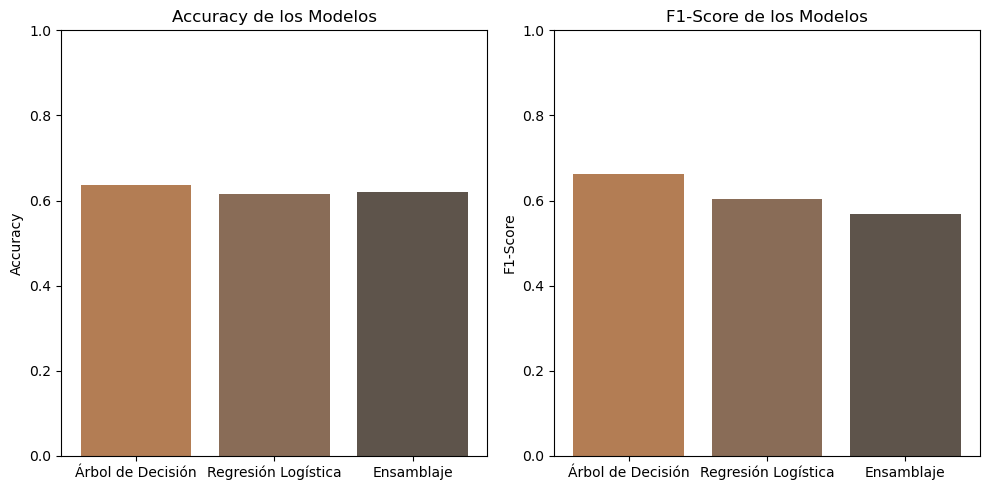

In [32]:
# Resultados
models = ['Árbol de Decisión', 'Regresión Logística', 'Ensamblaje']
accuracy_scores = [accuracy_tree, accuracy_log_reg, accuracy_voting]
f1_scores = [f1_tree, f1_log_reg, f1_voting]

# Gráfica de barras para Accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(models, accuracy_scores, color=['#B37D54', '#896C57', '#5E544B'])
plt.title('Accuracy de los Modelos')
plt.ylabel('Accuracy')
plt.ylim(0, 1)

# Gráfica de barras para F1-Score
plt.subplot(1, 2, 2)
plt.bar(models, f1_scores, color=['#B37D54', '#896C57', '#5E544B'])
plt.title('F1-Score de los Modelos')
plt.ylabel('F1-Score')
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

Árbol de Decisión:

Accuracy: 0.6373
F1-Score: 0.6617

El árbol de decisión logró una precisión del 63.73% en el conjunto de prueba y un puntaje F1 de 0.6617. Estos resultados sugieren que el modelo es capaz de predecir correctamente la popularidad de los artículos en Mashable en aproximadamente el 63.73% de los casos, y el puntaje F1 indica un buen equilibrio entre precisión y exhaustividad.

Regresión Logística:

Accuracy: 0.6147
F1-Score: 0.6041

La regresión logística obtuvo una precisión del 61.47% en el conjunto de prueba y un puntaje F1 de 0.6041. Aunque ligeramente inferior al árbol de decisión en términos de Accuracy, la diferencia en F1-Score es mínima, lo que sugiere que ambos modelos tienen un desempeño comparable.

Ensamblaje:

Accuracy: 0.6193
F1-Score: 0.5684

El ensamblaje de los dos modelos resultó en una precisión del 61.93% en el conjunto de prueba y un puntaje F1 de 0.5684. A pesar de que la precisión es ligeramente superior a la de la regresión logística, el puntaje F1 es más bajo, lo que indica que el ensamblaje no mejora significativamente el desempeño de los modelos individuales en este caso.

En resumen, el árbol de decisión muestra el mejor desempeño en términos de precisión y F1-Score, seguido por la regresión logística. El ensamblaje no logra superar el desempeño de los modelos individuales en este escenario particular. Es importante tener en cuenta que estos resultados pueden variar dependiendo de la naturaleza de los datos y la configuración de los modelos.


### Punto 7 - Votación Mayoritaria
En la celda 7 elabore un esamble con la metodología de **Votación mayoritaria** compuesto por 300 muestras bagged donde:

-las primeras 100 muestras vienen de árboles de decisión donde max_depth tome un valor de su elección\
-las segundas 100 muestras vienen de árboles de decisión donde min_samples_leaf tome un valor de su elección\
-las últimas 100 muestras vienen de regresiones logísticas

Evalúe cada uno de los tres modelos de manera independiente utilizando las métricas de Accuracy y F1-Score, luego evalúe el ensamble de modelos y compare los resultados. 

Nota: 

Para este ensamble de 300 modelos, deben hacer votación mayoritaria. Esto lo pueden hacer de distintas maneras. La más "fácil" es haciendo la votación "manualmente", como se hace a partir del minuto 5:45 del video de Ejemplo práctico de emsablajes en Coursera. Digo que es la más fácil porque si hacen la votación mayoritaria sobre las 300 predicciones van a obtener lo que se espera.

Otra opción es: para cada uno de los 3 tipos de modelos, entrenar un ensamble de 100 modelos cada uno. Predecir para cada uno de esos tres ensambles y luego predecir como un ensamble de los 3 ensambles. La cuestión es que la votación mayoritaria al usar los 3 ensambles no necesariamente va a generar el mismo resultado que si hacen la votación mayoritaria directamente sobre los 300 modelos. Entonces, para los que quieran hacer esto, deben hacer ese último cálculo con cuidado.

Para los que quieran hacerlo como ensamble de ensambles, digo que se debe hacer el ensamble final con cuidado por lo siguiente. Supongamos que:

* para los 100 árboles del primer tipo, la votación mayoritaria es: 55% de los modelos predicen que la clase de una observación es "1"
* para los 100 árboles del segundo tipo, la votación mayoritaria es: 55% de los modelos predicen que la clase de una observación es "1"
* para las 100 regresiones logísticas, la votación mayoritaria es: 10% de los modelos predicen que la clase de una observación es "1"

Si se hace la votación mayoritaria de los 300 modelos, la predicción de esa observación debería ser: (100*55%+100*55%+100*10%)/300 = 40% de los modelos votan porque la predicción debería ser "1". Es decir, la predicción del ensamble es "0" (dado que menos del 50% de modelos predijo un 1).

Sin embargo, si miramos cada ensamble por separado, el primer ensamble predice "1", el segundo ensamble predice "1" y el último ensamble predice "0". Si hago votación mayoritaria sobre esto, la predicción va a ser "1", lo cual es distinto a si se hace la votación mayoritaria sobre los 300 modelos.

In [34]:
# Celda 7

# Definición del modelo de árbol de decisión para el primer ensamble
tree_clf_depth = DecisionTreeClassifier(max_depth=5, random_state=1)

# Definición del modelo de árbol de decisión para el segundo ensamble
tree_clf_leaf = DecisionTreeClassifier(min_samples_leaf=5, random_state=1)

# Definición del modelo de regresión logística para el tercer ensamble
log_reg = LogisticRegression(max_iter=1000, random_state=1)

# División de los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenamiento del primer ensamble de árboles de decisión
bagging_tree_depth = BaggingClassifier(base_estimator=tree_clf_depth, n_estimators=100, random_state=1)
bagging_tree_depth.fit(X_train, y_train)

# Entrenamiento del segundo ensamble de árboles de decisión
bagging_tree_leaf = BaggingClassifier(base_estimator=tree_clf_leaf, n_estimators=100, random_state=1)
bagging_tree_leaf.fit(X_train, y_train)

# Entrenamiento del tercer ensamble de regresión logística
bagging_log_reg = BaggingClassifier(base_estimator=log_reg, n_estimators=100, random_state=1)
bagging_log_reg.fit(X_train, y_train)

# Predicciones de cada ensamble
y_pred_tree_depth = bagging_tree_depth.predict(X_test)
y_pred_tree_leaf = bagging_tree_leaf.predict(X_test)
y_pred_log_reg = bagging_log_reg.predict(X_test)

# Métricas de desempeño para cada modelo individual
accuracy_tree_depth = accuracy_score(y_test, y_pred_tree_depth)
f1_tree_depth = f1_score(y_test, y_pred_tree_depth)

accuracy_tree_leaf = accuracy_score(y_test, y_pred_tree_leaf)
f1_tree_leaf = f1_score(y_test, y_pred_tree_leaf)

accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)
f1_log_reg = f1_score(y_test, y_pred_log_reg)

print("Desempeño del Primer Ensamble (Árboles de Decisión con max_depth=5):")
print("Accuracy:", accuracy_tree_depth)
print("F1-Score:", f1_tree_depth)

print("\nDesempeño del Segundo Ensamble (Árboles de Decisión con min_samples_leaf=5):")
print("Accuracy:", accuracy_tree_leaf)
print("F1-Score:", f1_tree_leaf)

print("\nDesempeño del Tercer Ensamble (Regresión Logística):")
print("Accuracy:", accuracy_log_reg)
print("F1-Score:", f1_log_reg)

# Realización de la votación mayoritaria
y_pred_voting = np.round((y_pred_tree_depth + y_pred_tree_leaf + y_pred_log_reg) / 3)

# Métricas de desempeño del ensamble
accuracy_voting = accuracy_score(y_test, y_pred_voting)
f1_voting = f1_score(y_test, y_pred_voting)

print("\nDesempeño del Ensamble (Votación Mayoritaria):")
print("Accuracy:", accuracy_voting)
print("F1-Score:", f1_voting)


Desempeño del Primer Ensamble (Árboles de Decisión con max_depth=5):
Accuracy: 0.6666666666666666
F1-Score: 0.6649916247906198

Desempeño del Segundo Ensamble (Árboles de Decisión con min_samples_leaf=5):
Accuracy: 0.6625
F1-Score: 0.6672144617912901

Desempeño del Tercer Ensamble (Regresión Logística):
Accuracy: 0.6491666666666667
F1-Score: 0.6323144104803493

Desempeño del Ensamble (Votación Mayoritaria):
Accuracy: 0.67
F1-Score: 0.67


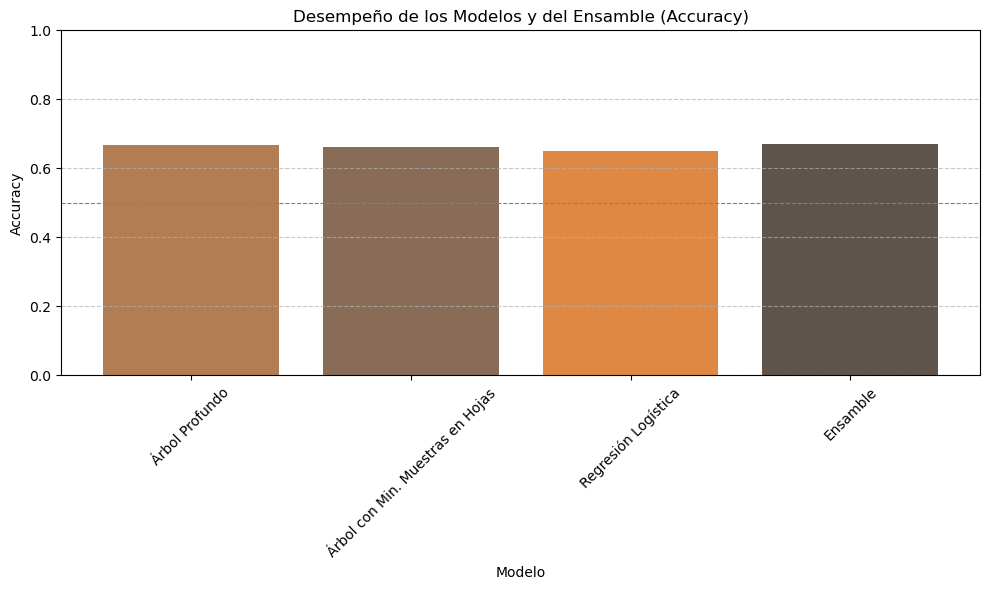

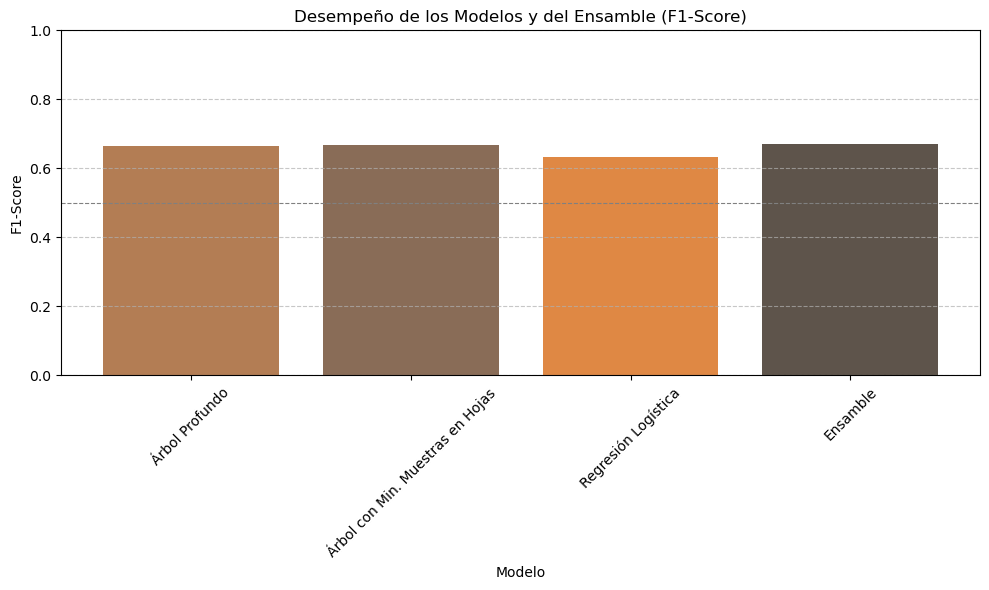

In [35]:
# Métricas de desempeño para cada modelo individual
models = ['Árbol Profundo', 'Árbol con Min. Muestras en Hojas', 'Regresión Logística', 'Ensamble']

accuracy_scores = [accuracy_tree_depth, accuracy_tree_leaf, accuracy_log_reg, accuracy_voting]
f1_scores = [f1_tree_depth, f1_tree_leaf, f1_log_reg, f1_voting]

# Gráfica de barras comparando Accuracy
plt.figure(figsize=(10, 6))
plt.bar(models, accuracy_scores, color=['#B37D54', '#896C57', '#DF8844', '#5E544B'])
plt.xlabel('Modelo')
plt.ylabel('Accuracy')
plt.title('Desempeño de los Modelos y del Ensamble (Accuracy)')
plt.ylim(0, 1)
plt.axhline(y=0.5, color='gray', linestyle='--', linewidth=0.8)  # Línea de referencia para el azar
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Gráfica de barras comparando F1-Score
plt.figure(figsize=(10, 6))
plt.bar(models, f1_scores, color=['#B37D54', '#896C57', '#DF8844', '#5E544B'])
plt.xlabel('Modelo')
plt.ylabel('F1-Score')
plt.title('Desempeño de los Modelos y del Ensamble (F1-Score)')
plt.ylim(0, 1)
plt.axhline(y=0.5, color='gray', linestyle='--', linewidth=0.8)  # Línea de referencia para el azar
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


### Punto 8 - Votación Ponderada
En la celda 8 elabore un ensamble con la metodología de **Votación ponderada** compuesto por 300 muestras bagged para los mismos tres escenarios del punto 7. Evalúe los modelos utilizando las métricas de Accuracy y F1-Score

In [36]:
# Celda 8


# Entrenar árboles de decisión con diferentes parámetros
tree_clf_depth = DecisionTreeClassifier(max_depth=5, random_state=1)
tree_clf_depth.fit(X_train, y_train)

tree_clf_leaf = DecisionTreeClassifier(min_samples_leaf=5, random_state=1)
tree_clf_leaf.fit(X_train, y_train)

# Entrenar regresión logística
log_reg = LogisticRegression(max_iter=1000, random_state=1)
log_reg.fit(X_train, y_train)

# Realizar predicciones para cada modelo
y_pred_tree_depth = tree_clf_depth.predict(X_test)
y_pred_tree_leaf = tree_clf_leaf.predict(X_test)
y_pred_log_reg = log_reg.predict(X_test)

# Calcular métricas de desempeño para cada modelo
accuracy_tree_depth = accuracy_score(y_test, y_pred_tree_depth)
f1_tree_depth = f1_score(y_test, y_pred_tree_depth)

accuracy_tree_leaf = accuracy_score(y_test, y_pred_tree_leaf)
f1_tree_leaf = f1_score(y_test, y_pred_tree_leaf)

accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)
f1_log_reg = f1_score(y_test, y_pred_log_reg)

# Crear ensamble con votación ponderada
voting_clf_weighted = VotingClassifier(estimators=[
    ('tree_depth', tree_clf_depth),
    ('tree_leaf', tree_clf_leaf),
    ('log_reg', log_reg)
], voting='soft', weights=[1, 1, 1])

# Entrenar el ensamble
voting_clf_weighted.fit(X_train, y_train)

# Realizar predicciones con el ensamble
y_pred_voting_weighted = voting_clf_weighted.predict(X_test)

# Calcular métricas de desempeño para el ensamble
accuracy_voting_weighted = accuracy_score(y_test, y_pred_voting_weighted)
f1_voting_weighted = f1_score(y_test, y_pred_voting_weighted)

# Mostrar resultados
print("Desempeño del Árbol de Decisión (Profundidad):")
print("Accuracy:", accuracy_tree_depth)
print("F1-Score:", f1_tree_depth)

print("\nDesempeño del Árbol de Decisión (Mínimo de Muestras en Hojas):")
print("Accuracy:", accuracy_tree_leaf)
print("F1-Score:", f1_tree_leaf)

print("\nDesempeño de la Regresión Logística:")
print("Accuracy:", accuracy_log_reg)
print("F1-Score:", f1_log_reg)

print("\nDesempeño del Ensamble con Votación Ponderada:")
print("Accuracy:", accuracy_voting_weighted)
print("F1-Score:", f1_voting_weighted)

Desempeño del Árbol de Decisión (Profundidad):
Accuracy: 0.645
F1-Score: 0.6525285481239805

Desempeño del Árbol de Decisión (Mínimo de Muestras en Hojas):
Accuracy: 0.5908333333333333
F1-Score: 0.5870479394449117

Desempeño de la Regresión Logística:
Accuracy: 0.6483333333333333
F1-Score: 0.6304728546409807

Desempeño del Ensamble con Votación Ponderada:
Accuracy: 0.6083333333333333
F1-Score: 0.6109271523178809


### Punto 9 - Comparación y análisis de resultados
En la celda 9 comente sobre los resultados obtenidos con las metodologías usadas en los puntos 7 y 8, compare los resultados y enuncie posibles ventajas o desventajas de cada una de ellas.

#### Ensamble con Votación Mayoritaria

Este método utiliza la votación mayoritaria para combinar las predicciones de tres ensambles diferentes: dos ensambles de árboles de decisión con diferentes parámetros (max_depth=5 y min_samples_leaf=5) y un ensamble de regresión logística.

El desempeño del ensamble con votación mayoritaria es bastante bueno, con un Accuracy de 0.67 y un F1-Score de 0.67.

Ventajas:

*La votación mayoritaria es simple de implementar y entender.

*Permite utilizar modelos heterogéneos (diferentes tipos de modelos base) en el ensamble.

Desventajas:

*Puede que no sea óptimo para todos los conjuntos de datos y modelos base, ya que no considera la confianza de cada modelo base en sus predicciones.

#### Ensamble con Votación Ponderada

En este método, se utiliza la votación ponderada para combinar las predicciones de tres ensambles de modelos base (dos ensambles de árboles de decisión y un ensamble de regresión logística), donde cada modelo contribuye a la predicción final con un peso específico.

A diferencia del método anterior, donde se utilizó la votación mayoritaria, aquí se ponderan las predicciones de acuerdo a un peso asignado a cada modelo.

Sin embargo, en este caso, el desempeño del ensamble con votación ponderada es inferior al método anterior, con un Accuracy de 0.608 y un F1-Score de 0.611.

Ventajas:

*Permite asignar mayor importancia a los modelos que tienen mejor desempeño en el conjunto de datos.

*Proporciona flexibilidad al ajustar los pesos de cada modelo base.

Desventajas:

*Requiere ajustar los pesos de los modelos, lo que puede ser más complejo que la votación mayoritaria.

*Si los pesos no se ajustan correctamente, el desempeño del ensamble puede verse afectado negativamente.
